In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, confusion_matrix, recall_score, precision_score
from sklearn.svm import SVC
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
import pickle

import os

In [2]:
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
df = pd.read_csv("data/train.csv", index_col=0)

In [4]:
df.columns

Index(['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price',
       'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver', 'Descargas', 'Descargas2', 'Categoria', 'tamaño',
       'tamaño2', 'Gratuito', 'tipo_contenido', 'Genero1',
       'dias_sin_actualizar', 'meses_sin_actualizar', 'grupomeses',
       'version_actual', 'grupoversiones', 'version_android', 'Genero2',
       'media_inst_grp_ver', 'mediana_inst_grp_ver', 'med_versandroid'],
      dtype='object')

<Axes: >

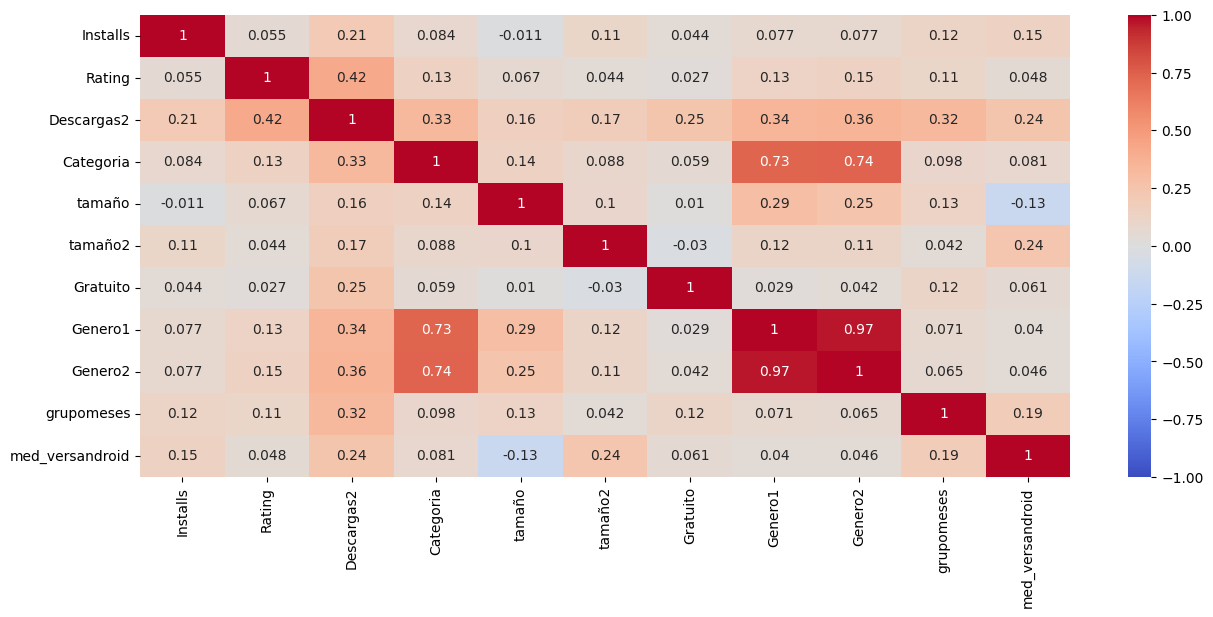

In [5]:
plt.figure(figsize=(15,6))
sns.heatmap(df[["Installs","Rating","Descargas2","Categoria","tamaño","tamaño2","Gratuito", "Genero1","Genero2", "grupomeses", "med_versandroid"]].corr(),vmin=-1, annot=True, cmap="coolwarm")

In [6]:
X = df.iloc[:,14:]
y = df['Descargas2']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [8]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(model.score(X_train,y_train))
print(accuracy_score(y_test, predictions))
print(recall_score(y_test,predictions, average="macro"))
print(confusion_matrix(y_test,predictions))

0.9910337552742616
0.3558368495077356
0.35104288674801937
[[ 79  36  25  26  24   4]
 [ 32  38  55  25  23   8]
 [ 38  40  80  54  30  13]
 [ 23  23  49  76  64  19]
 [ 16  24  38  51 130  58]
 [  5   6   9  19  79 103]]


In [9]:
pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values(by="Importance", ascending=False)

,Feature,Importance
6,dias_sin_actualizar,0.177335
1,tamaño,0.156099
11,version_android,0.087610
12,Genero2,0.085286
5,Genero1,0.082586
7,meses_sin_actualizar,0.079770
0,Categoria,0.074892
2,tamaño2,0.052978
9,version_actual,0.046496
8,grupomeses,0.044789


# RandomForest

In [10]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier())
])

rf_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['auto', 'sqrt', 'log2', None],
    'classifier__max_depth': [None] + list(randint(3, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 21),
    'classifier__min_samples_leaf': randint(1, 21),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_leaf_nodes': [None] + list(randint(2, 50).rvs(10)),
    'classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__random_state': [42],
    'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

search_space = [
    rf_params  ]

random_search_rf = RandomizedSearchCV(pipe,
                           search_space,
                           n_iter=20,
                           scoring='accuracy', 
                           refit='accuracy',
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)


random_search_rf.fit(X_train, y_train)
print(random_search_rf.best_params_)
best_model_rf = random_search_rf.best_estimator_
predictions_rf = best_model_rf.predict(X_test)

print(best_model_rf.score(X_train, y_train))
print(accuracy_score(y_test, predictions_rf))
print(recall_score(y_test, predictions_rf, average="macro"))
print(confusion_matrix(y_test, predictions_rf))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
9 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\javie\AppData\

{'classifier': RandomForestClassifier(), 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': 46, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 970, 'classifier__oob_score': True, 'classifier__random_state': 42, 'classifier__warm_start': True, 'scaler': None}
0.41543600562587907
0.33755274261603374
0.3261254833802188
[[ 85  20  32  15  38   4]
 [ 41  20  57  13  46   4]
 [ 49  25  83  35  54   9]
 [ 47   7  54  26 107  13]
 [ 26   3  46  22 163  57]
 [  5   0   8  11  94 103]]


# XGB

In [11]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier())
])

xgb_params = {
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None] + list(randint(3, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 21),
    'classifier__min_samples_leaf': randint(1, 21),
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_leaf_nodes': [None] + list(randint(2, 50).rvs(10)),
    'classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__random_state': [42],
    'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

search_space = [
    xgb_params  ]

random_search_xgb = RandomizedSearchCV(pipe,
                           search_space,
                           n_iter=20,
                           scoring='accuracy', 
                           refit='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)


random_search_xgb.fit(X_train, y_train)
print(random_search_xgb.best_params_)
best_model_xgb = random_search_xgb.best_estimator_
predictions_xgb = best_model_xgb.predict(X_test)

print(best_model_xgb.score(X_train, y_train))
print(accuracy_score(y_test, predictions_xgb))
print(recall_score(y_test, predictions_xgb, average="macro"))
print(confusion_matrix(y_test, predictions_xgb))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "bootstrap", "class_weight", "criterion", "max_features", "min_impurity_decrease", "min_samples_leaf", "min_samples_split", "oob_score", "warm_start" } are not used.

  warnings.warn(smsg, UserWarning)


{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 40, 'classifier__max_features': 'auto', 'classifier__max_leaf_nodes': None, 'classifier__min_imp

# Pipeline con varios modelos para ver si mejoramos el 0.3

In [24]:
pipe_multi = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier())
])

xgb_params = {
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': randint(50, 500),
    "classifier__learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0],
    "classifier__max_depth": [3, 4, 5, 6, 7],
    "classifier__min_child_weight": randint(1, 11),
    "classifier__subsample": [0.5, 0.7, 0.9, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 0.9, 1.0]
    
}

knn_params = {
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors':randint(1, 20),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}


gb_params = {
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': randint(50, 500),
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 11),
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0]
}

search_space_multi = [
    xgb_params,
    knn_params,
    gb_params  ]


rsm_multi = RandomizedSearchCV(pipe_multi,
                           search_space_multi,
                           n_iter=20,
                           scoring='accuracy', 
                           refit='accuracy',
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)

rsm_multi.fit(X_train, y_train)
print(rsm_multi.best_params_)
best_model_multi = rsm_multi.best_estimator_
predictions5 = best_model_multi.predict(X_test)

print(best_model_multi.score(X_train, y_train))
print(accuracy_score(y_test, predictions5))
print(recall_score(y_test, predictions5, average="macro"))
print(confusion_matrix(y_test, predictions5))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

# Agregamos PCA al mismo RandomForest
Con n=6 deberíamos estar en un 75%, en 12 de 16 ya al 100%


In [25]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('classifier', RandomForestClassifier())

])

rf_params = {
    "pca__n_components": randint(6,12),
    'scaler': [StandardScaler(), MinMaxScaler()],
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_depth': [None] + list(randint(3, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 21),
    'classifier__min_samples_leaf': randint(1, 21),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_leaf_nodes': [None] + list(randint(2, 50).rvs(10)),
    'classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': ['balanced_subsample', 'balanced'],
    'classifier__random_state': [42]
}

search_space = [
    rf_params  ]

random_search_rf = RandomizedSearchCV(pipe,
                           search_space,
                           n_iter=100,
                           scoring='accuracy', 
                           refit='accuracy',
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)


random_search_rf.fit(X_train, y_train)
print(random_search_rf.best_params_)
best_model_rf = random_search_rf.best_estimator_
predictions_rf = best_model_rf.predict(X_test)

print(best_model_rf.score(X_train, y_train))
print(accuracy_score(y_test, predictions_rf))
print(recall_score(y_test, predictions_rf, average="macro"))
print(confusion_matrix(y_test, predictions_rf))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'classifier': RandomForestClassifier(), 'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'entropy', 'classifier__max_depth': 45, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 12, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 472, 'classifier__random_state': 42, 'pca__n_components': 11, 'scaler': StandardScaler()}
0.6531293952180028
0.32841068917018285
0.33354685821357943
[[ 79  48  25  20  17   5]
 [ 37  51  38  28  20   7]
 [ 50  64  59  42  26  14]
 [ 44  31  58  47  44  30]
 [ 25  25  34  44 109  80]
 [  4   2  11  27  55 122]]


# XGB 
Con n=6 deberíamos estar en un 75%, en 12 de 16 ya al 100%

In [28]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('classifier', RandomForestClassifier())
])

xgb_params = {
    "pca__n_components": randint(6,12),
    "scaler": [StandardScaler(), MinMaxScaler()],
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None] + list(randint(3, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 21),
    'classifier__min_samples_leaf': randint(1, 21),
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_leaf_nodes': [None] + list(randint(2, 50).rvs(10)),
    'classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__random_state': [42],
    'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

search_space = [
    xgb_params  ]

random_search_xgb = RandomizedSearchCV(pipe,
                           search_space,
                           n_iter=60,
                           scoring='f1_macro', 
                           refit='f1_macro',
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)


random_search_xgb.fit(X_train, y_train)
print(random_search_xgb.best_params_)
best_model_xgb = random_search_xgb.best_estimator_
predictions_xgb = best_model_xgb.predict(X_test)

print(best_model_xgb.score(X_train, y_train))
print(accuracy_score(y_test, predictions_xgb))
print(precision_score(y_test,predictions5, average="macro"))
print(recall_score(y_test, predictions_xgb, average="macro"))
print(confusion_matrix(y_test, predictions_xgb))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "bootstrap", "class_weight", "criterion", "max_features", "max_leaf_nodes", "min_impurity_decrease", "min_samples_leaf", "min_samples_split", "oob_score", "warm_start" } are not used.

  warnings.warn(smsg, UserWarning)


{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 24, 'classifier__max_features': 'auto', 'classifier__max_leaf_nodes': 44, 'classifier__min_im

# Multi

In [30]:
pipe_multi = Pipeline(steps=[("scaler", StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('classifier', RandomForestClassifier())
])

xgb_params = {
    "pca__n_components": randint(6,12),
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': randint(50, 500),
    "classifier__learning_rate": [0.001, 0.01, 0.1, 0.5, 1.0],
    "classifier__max_depth": [3, 4, 5, 6, 7],
    "classifier__min_child_weight": randint(1, 11),
    "classifier__subsample": [0.5, 0.7, 0.9, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 0.9, 1.0]
    
}

knn_params = {
    "pca__n_components": randint(6,12),
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors':randint(1, 20),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}


gb_params = {
    "pca__n_components": randint(6,12),
    "scaler": [StandardScaler(), MinMaxScaler(), None],
    'classifier': [GradientBoostingClassifier()],
    'classifier__n_estimators': randint(50, 500),
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
    'classifier__max_depth': [3, 4, 5, 6, 7],
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 11),
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0]
}

search_space_multi = [
    xgb_params,
    knn_params,
    gb_params  ]


rsm_multi = RandomizedSearchCV(pipe_multi,
                           search_space_multi,
                           n_iter=20,
                           scoring='f1_macro', 
                           refit='f1_macro',
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)

rsm_multi.fit(X_train, y_train)
print(rsm_multi.best_params_)
best_model_multi = rsm_multi.best_estimator_
predictions5 = best_model_multi.predict(X_test)

print(best_model_multi.score(X_train, y_train))
print(accuracy_score(y_test, predictions5))
print(precision_score(y_test,predictions5, average="macro"))
print(recall_score(y_test, predictions5, average="macro"))
print(confusion_matrix(y_test, predictions5))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 12, 'classifier__p': 2, 'classifier__weights': 'distance', 'pca__n_components': 11, 'scaler': MinMaxScaler()}
0.9910337552742616
0.33122362869198313
0.3277735301620398
0.32809874699172353
[[ 71  30  31  31  25   6]
 [ 32  39  46  28  23  13]
 [ 49  34  76  47  37  12]
 [ 29  24  66  52  62  21]
 [ 22  21  41  52 124  57]
 [  4   4  11  21  72 109]]


# Apenas hay mejora, vamos a usar un RandomUnderSampler

In [33]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


## RandomForest

In [41]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('classifier', RandomForestClassifier())
])

rf_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), None],
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_depth': [None] + list(randint(3, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 21),
    'classifier__min_samples_leaf': randint(1, 21),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_leaf_nodes': [None] + list(randint(2, 50).rvs(10)),
    'classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__random_state': [42],
    'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

search_space = [
    rf_params  ]

random_search_rf = RandomizedSearchCV(pipe,
                           search_space,
                           n_iter=30,
                           scoring='f1_macro', 
                           refit='f1_macro',
                           cv=3,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)


random_search_rf.fit(X_train_resampled, y_train_resampled)
print(random_search_rf.best_params_)
best_model_rf = random_search_rf.best_estimator_
predictions_rf = best_model_rf.predict(X_test)

print(best_model_rf.score(X_train_resampled, y_train_resampled))
print(accuracy_score(y_test, predictions_rf))
print(precision_score(y_test,predictions_rf, average="macro"))
print(recall_score(y_test, predictions_rf, average="macro"))
print(confusion_matrix(y_test, predictions_rf))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'classifier': RandomForestClassifier(), 'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 443, 'classifier__oob_score': True, 'classifier__random_state': 42, 'classifier__warm_start': False, 'scaler': None}
0.5903426791277259
0.3241912798874824
0.3133164137073727
0.33421458666601117
[[ 87  37  25  25  14   6]
 [ 49  42  45  22  16   7]
 [ 47  71  54  39  23  21]
 [ 57  23  49  53  47  25]
 [ 26  27  38  51  83  92]
 [  4   6   9  18  42 142]]


## XGB

In [38]:
pipe = Pipeline(steps=[("scaler", StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('classifier', RandomForestClassifier())
])

xgb_params = {
    "pca__n_components": randint(6,12),
    "scaler": [StandardScaler(), MinMaxScaler()],
    'classifier': [XGBClassifier()],
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [None] + list(randint(3, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 21),
    'classifier__min_samples_leaf': randint(1, 21),
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_leaf_nodes': [None] + list(randint(2, 50).rvs(10)),
    'classifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__random_state': [42],
    'classifier__warm_start': [True, False],
    'classifier__oob_score': [True, False]
}

search_space = [
    xgb_params  ]

random_search_xgb = RandomizedSearchCV(pipe,
                           search_space,
                           n_iter=50,
                           scoring='f1_macro', 
                           refit='f1_macro',
                           cv=6,
                           n_jobs=-1,
                           verbose=1,
                           random_state=42)


random_search_xgb.fit(X_train_resampled, y_train_resampled)
print(random_search_xgb.best_params_)
best_model_xgb = random_search_xgb.best_estimator_
predictions_xgb = best_model_xgb.predict(X_test)

print("Model Score:",best_model_xgb.score(X_train_resampled, y_train_resampled))
print("Accuracy Score:",accuracy_score(y_test, predictions_xgb))
print("Precision Score:",precision_score(y_test,predictions5, average="macro"))
print("Recall Score:",recall_score(y_test, predictions_xgb, average="macro"))
print(confusion_matrix(y_test, predictions_xgb))

Fitting 6 folds for each of 50 candidates, totalling 300 fits


c:\Users\javie\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "bootstrap", "class_weight", "criterion", "max_features", "max_leaf_nodes", "min_impurity_decrease", "min_samples_leaf", "min_samples_split", "oob_score", "warm_start" } are not used.

  warnings.warn(smsg, UserWarning)


{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'classifier__bootstrap': False, 'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 22, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': 43, 'classifier__min_im